# Experiment Analysis

This notebook contains the visual inspections and plots for the set of experiments we've conducted: 3 priors (Standard Gaussian, Mixture of Gaussian, Vampprior) on 2 datasets (Freyfaces and static MNIST)

**Note on Jan 14, 2021**:

On this day, we re-run all the steps below in order to obtain the latest (and final) data for our report

## 0. Import libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps

sns.set_style('whitegrid')

%matplotlib inline

**Note about data on Google Cloud instance**

There are three folders containing experiment results on Google Cloud, each of them is associated with a set of experiments we've run, the details are as follow:

* `experiments_weights_from_training`: All 3 priors on 2 datasets, the weights of the pseudo-inputs are initialized from training data

* `experiments_mnist_with_mog`: The only updated experiment is the one with MNIST dataset and MoG prior

* `experiments_freyfaces_with_mog`: The updated experiment is the one with Freyfaces and MoG. Since Sam wasn't able to run this experiment on his computer, Erik ran this experiment on GCP once again.

### <span style="background:yellow">! Important</span>

One our local machine, all data will be put into `experiments` (unless specified otherwise). To that end:
* Data for SG and Vampprior will be downloaded from `experiments_weights_from_training` on GCP.
* Data for MNIST + MOG will be downloaded from `experiments_mnist_with_mog`.
* Data for Freyfaces + MOG will be downloaded from `experiments_freyfaces_with_mog`

## 1. MNIST

Download the loss data from GCP

In [42]:
# !rsync -avz --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/log experiments/mnist/vamp/log.json
# !rsync -avz --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/standard/log experiments/mnist/standard/log.json
# !rsync -avz --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_mnist_with_mog/mnist/mog/log experiments/mnist/mog/log.json

**MNIST Vampprior data**

In [43]:
def make_loss_df(dataset='mnist', prior='vamp'):
    with open(f'./experiments/{dataset}/{prior}/log.json', 'r') as f:
        data = json.load(f)
    
    losses = {
        'train_loss': data['trainloss'],
        'train_re': data['trainre'],
        'train_kl': data['trainkl'],
        'test_loss': data['testloss'],
        'test_re': data['testre'],
        'test_kl': data['testkl'],
    }
    
    df = pd.DataFrame(losses)
    
    return df

In [71]:
mnist_vamp_losses = make_loss_df('mnist', 'vamp')
mnist_mog_losses = make_loss_df('mnist', 'mog')
mnist_sg_losses = make_loss_df('mnist', 'standard')

In [72]:
print('Vampprior: ', mnist_vamp_losses[['test_loss']].min(), mnist_vamp_losses[['test_kl']].min(), mnist_vamp_losses[['test_re']].min())
print('MoG: ', mnist_mog_losses[['test_loss']].min(), mnist_mog_losses[['test_kl']].min(), mnist_mog_losses[['test_re']].min())
print('SG: ', mnist_sg_losses[['test_loss']].min(), mnist_sg_losses[['test_kl']].min(), mnist_sg_losses[['test_re']].min())

Vampprior:  test_loss    93.292897
dtype: float64 test_kl    26.611981
dtype: float64 test_re   -95.343235
dtype: float64
MoG:  test_loss   -9.303285
dtype: float64 test_kl   -57.436697
dtype: float64 test_re   -86.643956
dtype: float64
SG:  test_loss    95.724423
dtype: float64 test_kl    26.469367
dtype: float64 test_re   -88.10064
dtype: float64


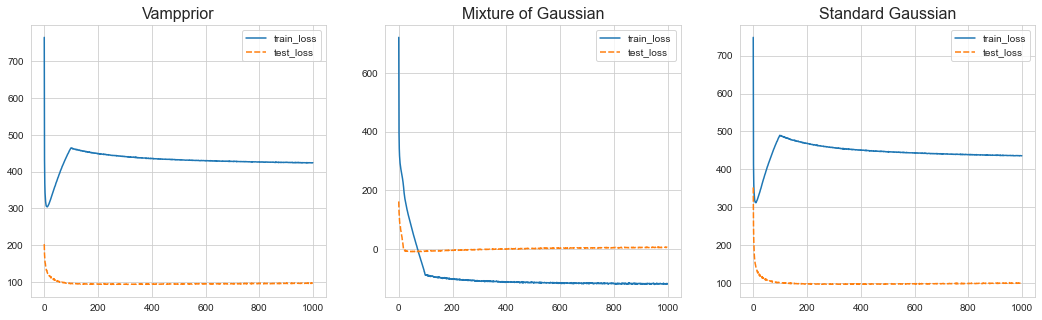

In [46]:
# fig = plt.figure(figsize=(15, 5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
sns.lineplot(data=mnist_sg_losses[['train_loss', 'test_loss']], ax=ax3)
ax3.set_title('Standard Gaussian', fontsize=16)

# There are data points for 2000 epochs, but we only need 1000
# Believe me, the rest 1000 is not that meaningful
sns.lineplot(data=mnist_mog_losses[['train_loss', 'test_loss']][:1000], ax=ax2)
ax2.set_title('Mixture of Gaussian', fontsize=16)

sns.lineplot(data=mnist_vamp_losses[['train_loss', 'test_loss']], ax=ax1)
ax1.set_title('Vampprior', fontsize=16)
plt.show();

There are a couple of ways that we could make the above plot look nicer:

* Instead of plotting 1000 data points in each subplot, we could sample evenly every 10 data points ending up with 100 data points and plot them.
* Make the lines thicker
* Make the numbers on both axes a bit bigger
* Make the border of each subplot darker to highlight the inside content
* Increase the distance between the title of each subplot to the graphs

In [47]:
indexes = [i for i in range(0, 1000, 10)]
sg_losses = mnist_sg_losses.iloc[indexes]
mog_losses = mnist_mog_losses.iloc[indexes]
vampp_losses = mnist_vamp_losses.iloc[indexes]

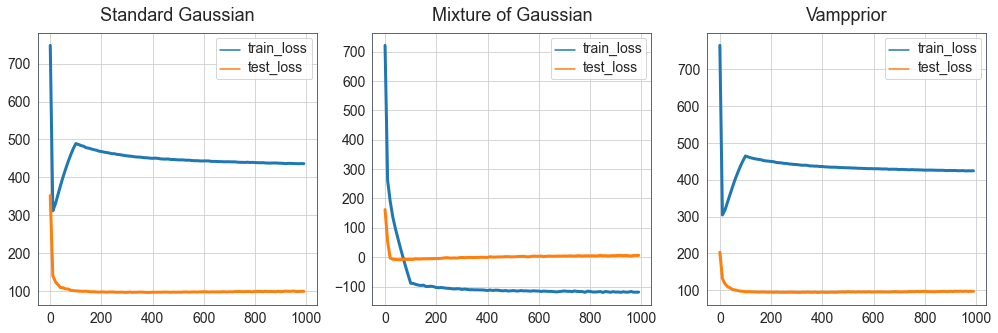

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.set_title('Standard Gaussian', fontsize=18, pad=12)
sns.lineplot(data=sg_losses[['train_loss', 'test_loss']], ax=ax1, linewidth=3, dashes=False)

ax2.yaxis.set_ticks(np.arange(-100, 701, 100))
ax2.set_title('Mixture of Gaussian', fontsize=18, pad=12)
sns.lineplot(data=mog_losses[['train_loss', 'test_loss']][:1000], ax=ax2, linewidth=3, dashes=False)

ax3.set_title('Vampprior', fontsize=18, pad=12)
sns.lineplot(data=vampp_losses[['train_loss', 'test_loss']], ax=ax3, linewidth=3, dashes=False)

# Change the spine color of each subplot
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.spines.values(), color='#374151')

# bbox_inches is set to `tight` to reduce the left and right margins of the
# figure in the generated PDF file
fig.savefig('./plots/mnist_train_test_losses.pdf', bbox_inches='tight')
plt.show();

### 1.2. Visualize KL and RE losses

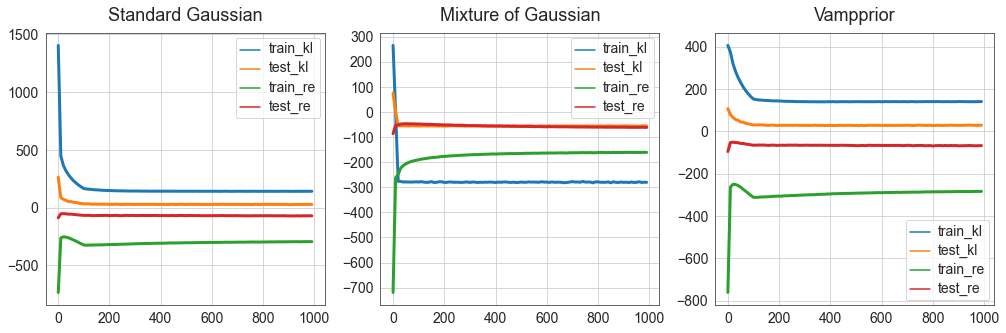

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.set_title('Standard Gaussian', fontsize=18, pad=12)
sns.lineplot(data=sg_losses[['train_kl', 'test_kl', 'train_re', 'test_re']], ax=ax1, linewidth=3, dashes=False)

ax2.yaxis.set_ticks(np.arange(-800, 301, 100))
ax2.set_title('Mixture of Gaussian', fontsize=18, pad=12)
sns.lineplot(data=mog_losses[['train_kl', 'test_kl', 'train_re', 'test_re']][:1000], ax=ax2, linewidth=3, dashes=False)

ax3.set_title('Vampprior', fontsize=18, pad=12)
sns.lineplot(data=vampp_losses[['train_kl', 'test_kl', 'train_re', 'test_re']], ax=ax3, linewidth=3, dashes=False)

# Change the spine color of each subplot
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.spines.values(), color='#374151')
    
fig.savefig('./plots/mnist_kl_re_losses.pdf', bbox_inches='tight')

## 2. Freyfaces

Download the loss data from GCP

In [53]:
# !rsync -avz --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/vamp/log experiments/freyfaces/vamp/log.json
# !rsync -avz --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/standard/log experiments/freyfaces/standard/log.json
# !rsync -avz --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/log experiments/freyfaces/mog/log.json

In [54]:
ff_vamp_losses = make_loss_df('freyfaces', 'vamp')
ff_mog_losses = make_loss_df('freyfaces', 'mog')
ff_sg_losses = make_loss_df('freyfaces', 'standard')

#### **What is the best loss for MoG?**

In [68]:
print('Vampprior: ', ff_vamp_losses[['test_loss']].min())
print('MoG: ', ff_mog_losses[['test_loss']].min())
print('SG: ', ff_sg_losses[['test_loss']].min())

Vampprior:  test_loss    1757.188538
dtype: float64
MoG:  test_loss    1937.301697
dtype: float64
SG:  test_loss    1774.228333
dtype: float64


In [69]:
print('Vampprior: ', ff_vamp_losses[['test_kl']].min())
print('MoG: ', ff_mog_losses[['test_kl']].min())
print('SG: ', ff_sg_losses[['test_kl']].min())

Vampprior:  test_kl    0.759955
dtype: float64
MoG:  test_kl   -45.273023
dtype: float64
SG:  test_kl    43.226515
dtype: float64


In [70]:
print('Vampprior: ', ff_vamp_losses[['test_re']].min())
print('MoG: ', ff_mog_losses[['test_re']].min())
print('SG: ', ff_sg_losses[['test_re']].min())

Vampprior:  test_re   -3403.672485
dtype: float64
MoG:  test_re   -3252.890381
dtype: float64
SG:  test_re   -3233.427734
dtype: float64


In [55]:
indexes = [i for i in range(0, 999, 10)]
sg_losses = ff_sg_losses.iloc[indexes]
# mog_losses = ff_mog_losses.iloc[indexes]
vampp_losses = ff_vamp_losses.iloc[indexes]

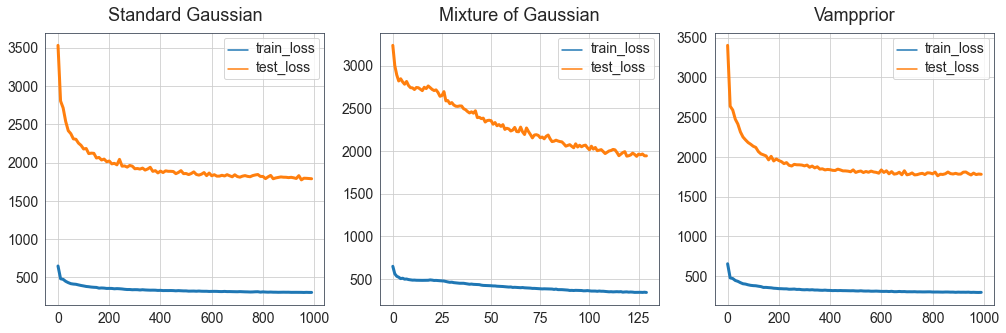

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.set_title('Standard Gaussian', fontsize=18, pad=12)
sns.lineplot(data=sg_losses[['train_loss', 'test_loss']], ax=ax1, linewidth=3, dashes=False)

ax2.set_title('Mixture of Gaussian', fontsize=18, pad=12)
sns.lineplot(data=ff_mog_losses[['train_loss', 'test_loss']], ax=ax2, linewidth=3, dashes=False)

ax3.set_title('Vampprior', fontsize=18, pad=12)
sns.lineplot(data=vampp_losses[['train_loss', 'test_loss']], ax=ax3, linewidth=3, dashes=False)

# Change the spine color of each subplot
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.spines.values(), color='#374151')

# bbox_inches is set to `tight` to reduce the left and right margins of the
# figure in the generated PDF file
fig.savefig('./plots/freyfaces_train_test_losses.pdf', bbox_inches='tight')
plt.show();

### 2.2. Visualize KL and RE losses

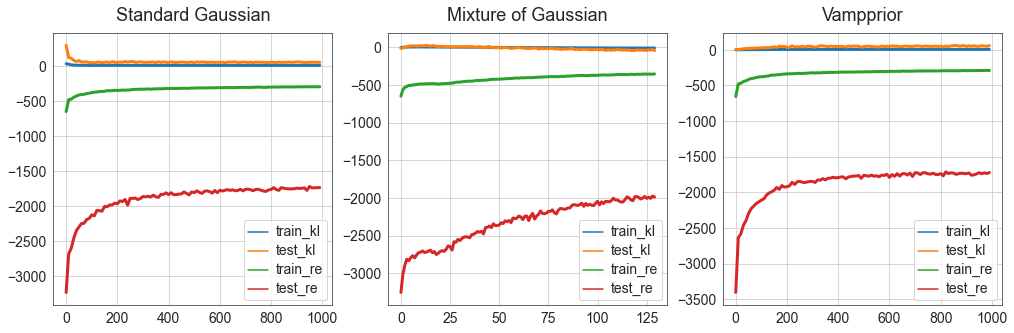

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.set_title('Standard Gaussian', fontsize=18, pad=12)
sns.lineplot(data=sg_losses[['train_kl', 'test_kl', 'train_re', 'test_re']], ax=ax1, linewidth=3, dashes=False)

ax2.yaxis.set_ticks(np.arange(-3000, 101, 500))
ax2.set_title('Mixture of Gaussian', fontsize=18, pad=12)
sns.lineplot(data=ff_mog_losses[['train_kl', 'test_kl', 'train_re', 'test_re']], ax=ax2, linewidth=3, dashes=False)

ax3.set_title('Vampprior', fontsize=18, pad=12)
sns.lineplot(data=vampp_losses[['train_kl', 'test_kl', 'train_re', 'test_re']], ax=ax3, linewidth=3, dashes=False)

# Change the spine color of each subplot
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.setp(ax.spines.values(), color='#374151')
    
fig.savefig('./plots/freyfaces_kl_re_losses.pdf', bbox_inches='tight')

# 3. Visualize the generated images

In this section, we visualize the generate images at different epoch during training: 100, 200, 400, 800, 1000

## 3.1. MNIST

Download data from GCP

In [12]:
!echo "Downloading MNIST Vampp data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch100.png experiments/mnist/vamp/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch200.png experiments/mnist/vamp/images/epoch200.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch400.png experiments/mnist/vamp/images/epoch400.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch800.png experiments/mnist/vamp/images/epoch800.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch1000.png experiments/mnist/vamp/images/epoch1000.png

!echo "Done MNIST Vampp data" 

Done MNIST Vampp data


In [13]:
!echo "Downloading MNIST SG data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/standard/images/epoch100.png experiments/mnist/standard/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/standard/images/epoch200.png experiments/mnist/standard/images/epoch200.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/standard/images/epoch400.png experiments/mnist/standard/images/epoch400.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/standard/images/epoch800.png experiments/mnist/standard/images/epoch800.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/standard/images/epoch1000.png experiments/mnist/standard/images/epoch1000.png

!echo "Done MNIST SG data" 

Done MNIST SG data


In [14]:
def display_images(
    nrows=1,
    ncols=5,
    dataset='mnist',
    prior='vamp',
    crop_border=(55,55,55,55),
    outfilename='./plots/'
):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    epochs = [100, 200, 400, 800, 1000]
    images = []
    for idx, epoch in enumerate(epochs):
        # Read and crop the image
        path = f'./experiments/{dataset}/{prior}/images/epoch{epoch}.png'
        img = Image.open(path)
        img = ImageOps.crop(img, crop_border)

        # Display the image
        ax.ravel()[idx].imshow(img)
        ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
        ax.ravel()[idx].set_axis_off()
    
    plt.tight_layout()
    fig.savefig(outfilename, bbox_inches='tight')
    plt.show()

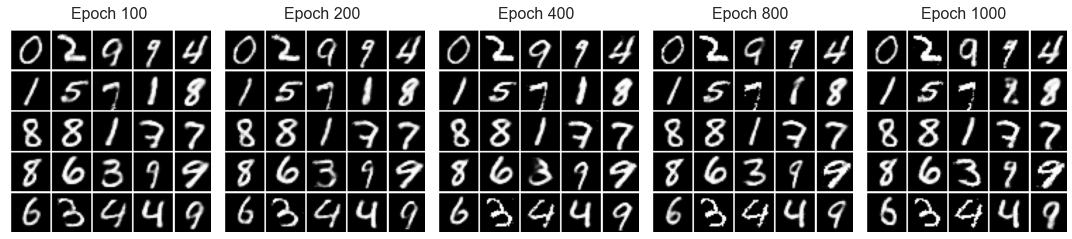

In [15]:
display_images(dataset='mnist', prior='vamp', outfilename='./plots/mnist_vamp_epoch_images.pdf')

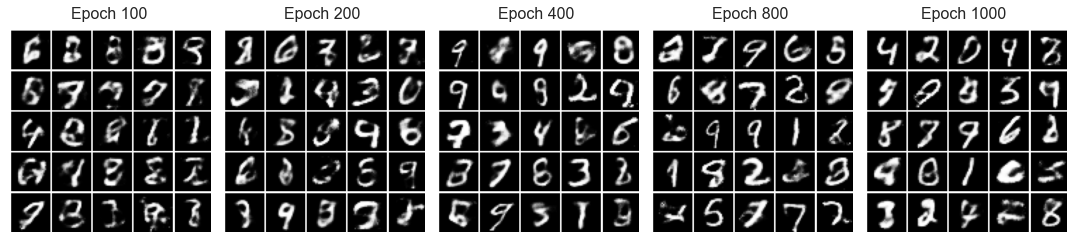

In [16]:
display_images(dataset='mnist', prior='standard', outfilename='./plots/mnist_standard_epoch_images.pdf')

In [17]:
!echo "Downloading MNIST MoG data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_mnist_with_mog/mnist/mog/images/epoch100.png experiments/mnist/mog/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_mnist_with_mog/mnist/mog/images/epoch200.png experiments/mnist/mog/images/epoch200.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_mnist_with_mog/mnist/mog/images/epoch400.png experiments/mnist/mog/images/epoch400.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_mnist_with_mog/mnist/mog/images/epoch800.png experiments/mnist/mog/images/epoch800.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_mnist_with_mog/mnist/mog/images/epoch1000.png experiments/mnist/mog/images/epoch1000.png

!echo "Done MNIST MoG data" 

Done MNIST MoG data


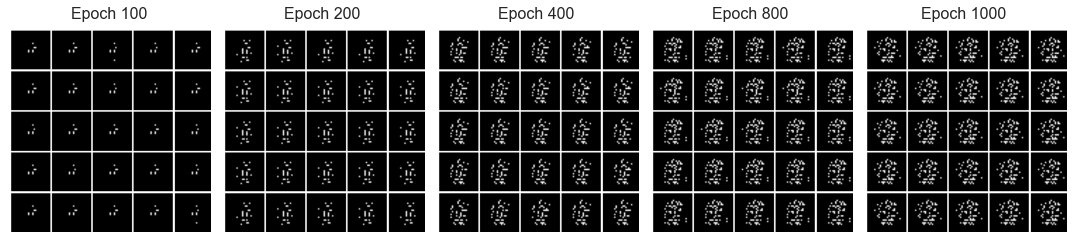

In [18]:
display_images(dataset='mnist', prior='mog', outfilename='./plots/mnist_mog_epoch_images.pdf')

### 2.* MNIST Vampprior with pseudo-inputs NOT initialized from training data

In [19]:
!mkdir -p experiments/mnist/vamp_unitialized/images
!echo "Downloading MNIST Vampprior* data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch100.png experiments/mnist/vamp_unitialized/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch200.png experiments/mnist/vamp_unitialized/images/epoch200.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch400.png experiments/mnist/vamp_unitialized/images/epoch400.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch800.png experiments/mnist/vamp_unitialized/images/epoch800.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch1000.png experiments/mnist/vamp_unitialized/images/epoch1000.png

!echo "Done MNIST Vampprior* data"

Done MNIST Vampprior* data


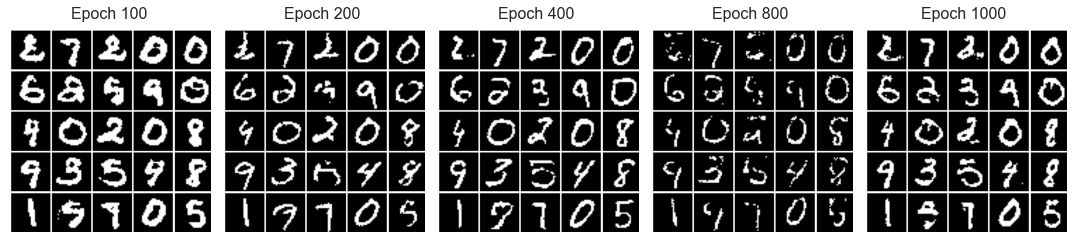

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [100, 200, 400, 800, 1000]
images = []
for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/mnist/vamp_unitialized/images/epoch{epoch}.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (55,55,55,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/mnist_pseudo_not_from_data_epochs.pdf', bbox_inches='tight')

## 3.2. Freyfaces

In [21]:
!echo "Downloading Freyfaces Vampp data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/vamp/images/epoch100.png experiments/freyfaces/vamp/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/vamp/images/epoch200.png experiments/freyfaces/vamp/images/epoch200.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/vamp/images/epoch400.png experiments/freyfaces/vamp/images/epoch400.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/vamp/images/epoch800.png experiments/freyfaces/vamp/images/epoch800.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/vamp/images/epoch1000.png experiments/freyfaces/vamp/images/epoch1000.png

!echo "Done Freyfaces Vampp data" 

Done Freyfaces Vampp data


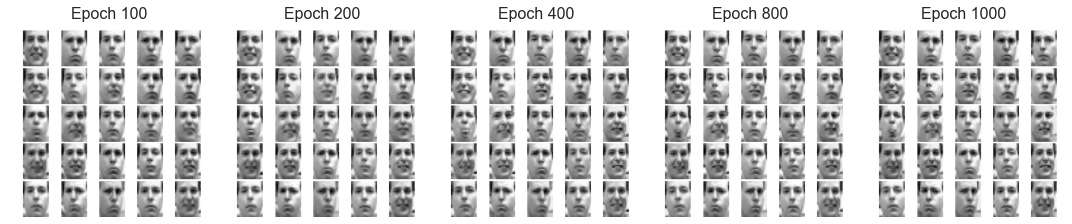

In [22]:
display_images(
    dataset='freyfaces',
    prior='vamp',
    crop_border=(40,55,40,55),
    outfilename='./plots/freyfaces_vamp_epoch_images.pdf')

In [23]:
!echo "Downloading Freyfaces SG data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/standard/images/epoch100.png experiments/freyfaces/standard/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/standard/images/epoch200.png experiments/freyfaces/standard/images/epoch200.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/standard/images/epoch400.png experiments/freyfaces/standard/images/epoch400.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/standard/images/epoch800.png experiments/freyfaces/standard/images/epoch800.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/freyfaces/standard/images/epoch1000.png experiments/freyfaces/standard/images/epoch1000.png

!echo "Done Freyfaces SG data" 

Done Freyfaces SG data


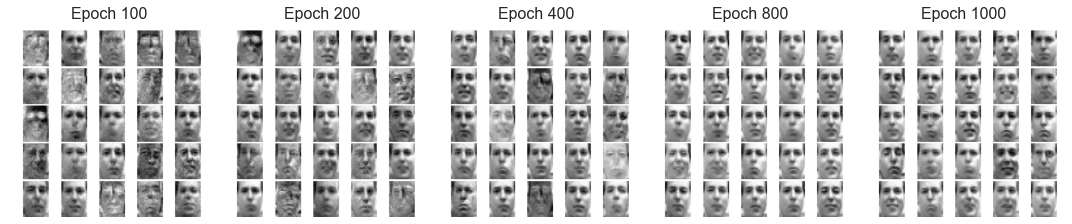

In [24]:
display_images(
    dataset='freyfaces',
    prior='standard',
    crop_border=(40,55,40,55),
    outfilename='./plots/freyfaces_standard_epoch_images.pdf')

In [25]:
!echo "Downloading Freyfaces MoG data"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/images/epoch20.png experiments/freyfaces/mog/images/epoch20.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/images/epoch40.png experiments/freyfaces/mog/images/epoch40.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/images/epoch60.png experiments/freyfaces/mog/images/epoch60.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/images/epoch80.png experiments/freyfaces/mog/images/epoch80.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/images/epoch100.png experiments/freyfaces/mog/images/epoch100.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_freyfaces_with_mog/freyfaces/mog/images/epoch120.png experiments/freyfaces/mog/images/epoch120.png

!echo "Done Freyfaces MoG data" 

Done Freyfaces MoG data


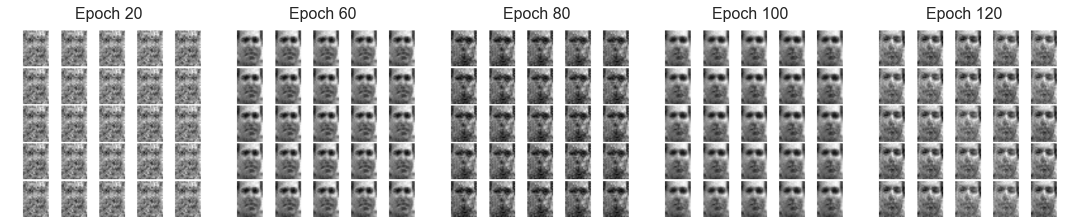

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [20, 60, 80, 100, 120]
images = []
for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/freyfaces/mog/images/epoch{epoch}.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (40,55,40,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/freyfaces_mog_epoch_images.pdf', bbox_inches='tight')
plt.show()

### 3.2.3 - Freyfaces generated images from Sam

**Standard Gaussian**

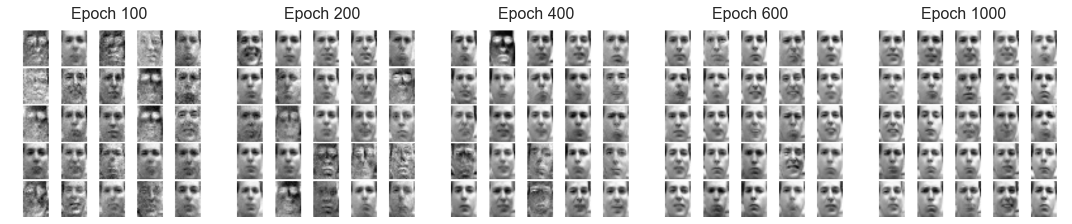

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [100, 200, 400, 600, 1000]
images = []
for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/freyfaces/sam_frey_standard/epoch{epoch}.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (40,55,40,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/freyfaces_standard_epoch_images.pdf', bbox_inches='tight')

**Vampprior, pseudo-inputs initialized from training**

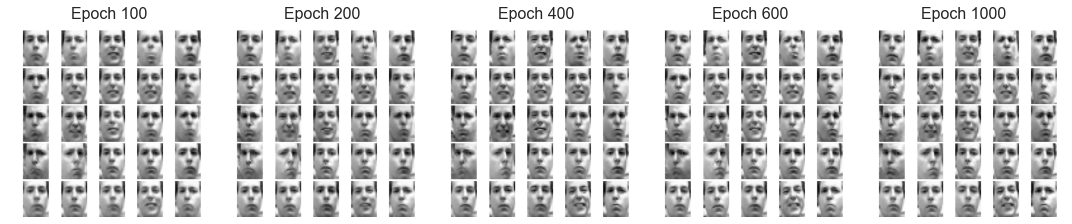

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [100, 200, 400, 600, 1000]
images = []
for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/freyfaces/sam_frey_vamp_sample_pseudo/epoch{epoch}.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (40,55,40,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/freyfaces_vamp_sample_pseudo_epoch_images.pdf', bbox_inches='tight')

**Vampprior, pseudo-inputs NOT initialized from training**

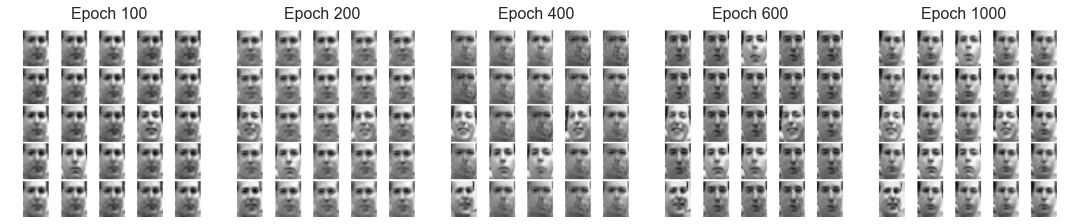

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [100, 200, 400, 600, 1000]
images = []
for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/freyfaces/sam_frey_vamp_not_sample_pseudos/epoch{epoch}.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (40,55,40,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/freyfaces_vamp_not_sample_pseudo_epoch_images.pdf', bbox_inches='tight')

## 4. Visualize the pseudo-inputs

### 4.1. **Vampprior learned pseudo-inputs which aren't initialized from training data**

In [32]:
!echo "Downloading Vampprior pseudo-inputs uninitialized"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch100_pseudos.png experiments/mnist/vamp_unitialized/images/epoch100_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch200_pseudos.png experiments/mnist/vamp_unitialized/images/epoch200_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch400_pseudos.png experiments/mnist/vamp_unitialized/images/epoch400_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch800_pseudos.png experiments/mnist/vamp_unitialized/images/epoch800_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/images/epoch1000_pseudos.png experiments/mnist/vamp_unitialized/images/epoch1000_pseudos.png
!echo "Done Vampprior pseudo-inputs uninitialized"

Done Vampprior pseudo-inputs uninitialized


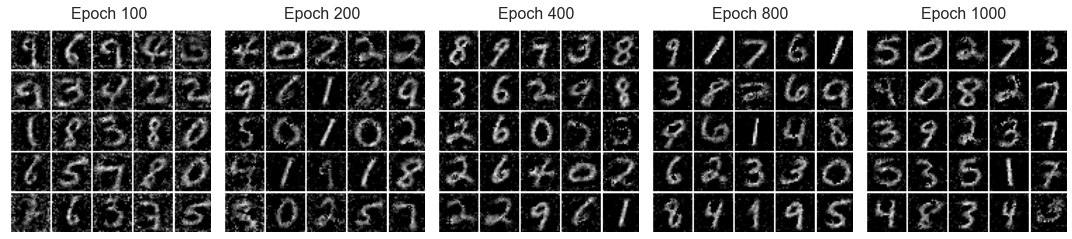

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [100, 200, 400, 800, 1000]

for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/mnist/vamp_unitialized/images/epoch{epoch}_pseudos.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (55,55,55,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {epoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/mnist_vamp_pseudo_uninit.pdf', bbox_inches='tight')

### 4.2. **Vampprior learned pseudo-inputs which ARE initialized from training data**

In [38]:
!echo "Downloading Vampprior pseudo-inputs initialized"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch100_pseudos.png experiments/mnist/vamp/images/epoch100_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch200_pseudos.png experiments/mnist/vamp/images/epoch200_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch400_pseudos.png experiments/mnist/vamp/images/epoch400_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch800_pseudos.png experiments/mnist/vamp/images/epoch800_pseudos.png
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project_old/our_code/experiments_weights_from_training/mnist/vamp/images/epoch1000_pseudos.png experiments/mnist/vamp/images/epoch1000_pseudos.png
!echo "Done Vampprior pseudo-inputs initialized"

Done Vampprior pseudo-inputs initialized


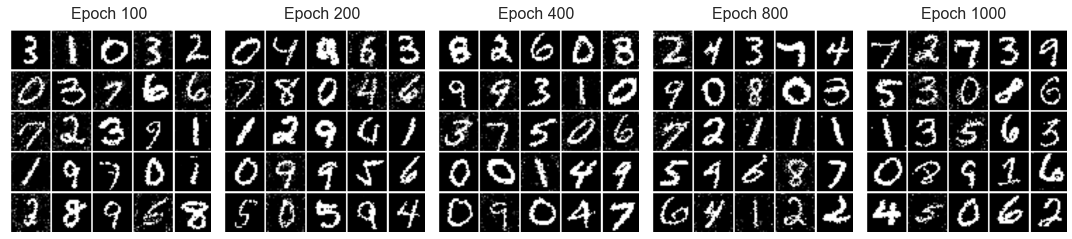

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
epochs = [100, 200, 400, 800, 1000]

for idx, epoch in enumerate(epochs):
    # Read and crop the image
    path = f'./experiments/mnist/vamp/images/epoch{epoch}_pseudos.png'
    img = Image.open(path)
    img = ImageOps.crop(img, (55,55,55,55))

    # Display the image
    ax.ravel()[idx].imshow(img)
    ax.ravel()[idx].set_title(f'Epoch {ebpoch}', fontsize=16, pad=10)
    ax.ravel()[idx].set_axis_off()

plt.tight_layout()
fig.savefig('./plots/mnist_vamp_pseudo_init.pdf', bbox_inches='tight')

## 5. Losses data for Vampprior uninitialized

In [73]:
!echo "Downloading Vampprior pseudo-inputs initialized"
!rsync -az --no-owner --no-group cuongdd@dd2434-vm:~/VAE_project/our_code/experiments/mnist/vamp/not_pseudo_from_data/log experiments/mnist/vamp_unitialized/log.json
!echo "Done Vampprior pseudo-inputs initialized"

Done Vampprior pseudo-inputs initialized


In [75]:
with open(f'./experiments/mnist/vamp_unitialized/log.json', 'r') as f:
    data = json.load(f)

losses = {
    'train_loss': data['trainloss'],
    'train_re': data['trainre'],
    'train_kl': data['trainkl'],
    'test_loss': data['testloss'],
    'test_re': data['testre'],
    'test_kl': data['testkl'],
}

df = pd.DataFrame(losses)

In [77]:
print('Vampprior: ', df[['test_loss']].min(), df[['test_kl']].min(), df[['test_re']].min())

Vampprior:  test_loss    91.876556
dtype: float64 test_kl    26.304079
dtype: float64 test_re   -90.438787
dtype: float64
